## Libraries

In [3]:
import pathlib
import time
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import torch.nn.functional as F

## Baseline Model Implementation
* Used the model from the in-class example but dtrained it in the fashion csv data instead

In [4]:
torch.manual_seed(0)

In [5]:
train_filepath = pathlib.Path('fashion_mnist/fashion-mnist_train.csv')
test_filepath = pathlib.Path('fashion_mnist/fashion-mnist_test.csv')

In [6]:
train_df = pl.read_csv(train_filepath)
test_df = pl.read_csv(test_filepath)

pixel_columns = [f'pixel{i}' for i in range(1, 785)]

train_features = train_df.select(pl.col(pixel_columns)).with_columns(
    pl.all() / 255.0  
)
train_target = train_df.select(pl.col("label")).cast(
    pl.Int32
).to_dummies()

test_features = test_df.select(pl.col(pixel_columns)).with_columns(
    pl.all() / 255.0  
)
test_target = test_df.select(pl.col("label")).cast(
    pl.Int32
).to_dummies()

print(train_features.head())
print(train_target.head())
print(test_features.head())
print(test_target.head())

shape: (5, 784)
┌────────┬────────┬────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ pixel1 ┆ pixel2 ┆ pixel3 ┆ pixel4   ┆ … ┆ pixel781 ┆ pixel782 ┆ pixel783 ┆ pixel784 │
│ ---    ┆ ---    ┆ ---    ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64    ┆ f64    ┆ f64    ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞════════╪════════╪════════╪══════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 0.0    ┆ 0.0    ┆ 0.0    ┆ 0.0      ┆ … ┆ 0.0      ┆ 0.0      ┆ 0.0      ┆ 0.0      │
│ 0.0    ┆ 0.0    ┆ 0.0    ┆ 0.0      ┆ … ┆ 0.0      ┆ 0.0      ┆ 0.0      ┆ 0.0      │
│ 0.0    ┆ 0.0    ┆ 0.0    ┆ 0.0      ┆ … ┆ 0.0      ┆ 0.0      ┆ 0.0      ┆ 0.0      │
│ 0.0    ┆ 0.0    ┆ 0.0    ┆ 0.003922 ┆ … ┆ 0.0      ┆ 0.0      ┆ 0.0      ┆ 0.0      │
│ 0.0    ┆ 0.0    ┆ 0.0    ┆ 0.0      ┆ … ┆ 0.0      ┆ 0.0      ┆ 0.0      ┆ 0.0      │
└────────┴────────┴────────┴──────────┴───┴──────────┴──────────┴──────────┴──────────┘
shape: (5, 10)
┌

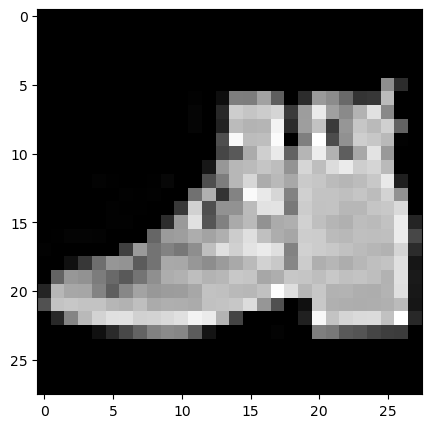

In [7]:
test_image = train_features[56].to_numpy().reshape(28, 28)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(
    test_image,
    cmap='gray', 
    vmin=0, 
    vmax=1
)
plt.show()

In [8]:
# Custom Dataset class
class MNISTDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image = self.features[idx].reshape(28, 28).astype('float32')
        label = self.targets[idx].astype('float32')
        return torch.tensor(image), torch.tensor(label)

In [9]:
X_train_full = train_features.to_numpy()
y_train_full = train_target.to_numpy()

X_test = test_features.to_numpy()
y_test = test_target.to_numpy()

# Split train data into training and validation sets (85-15 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, 
    y_train_full, 
    test_size=0.15, 
    random_state=42
)

train_dataset = MNISTDataset(X_train, y_train)
val_dataset = MNISTDataset(X_val, y_val)
test_dataset = MNISTDataset(X_test, y_test)

# Inspect the shapes of your datasets
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (51000, 784)
Training labels shape: (51000, 10)
Validation data shape: (9000, 784)
Validation labels shape: (9000, 10)
Test data shape: (10000, 784)
Test labels shape: (10000, 10)


In [10]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.relufc = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 5 * 5)
        x = self.fc1(x)
        x = self.relufc(x)
        x = self.fc2(x)
        return x

In [11]:
num_epochs = 10
batch_size = 64
learning_rate = 0.001

In [12]:
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
)
val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

In [13]:
model = SimpleCNN()
model

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (relufc): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [16]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()

training_history = []
for epoch in range(num_epochs):
    model.train()
    running_training_loss = 0.0
    for images, labels in train_loader:
        images = images.unsqueeze(1).to(device)  # Add channel dimension
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()

    training_loss = running_training_loss / len(train_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Training',
        'loss': training_loss
    })
    
    # Validation step
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.unsqueeze(1).to(device)  # Add channel dimension
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
    validation_loss = running_val_loss / len(val_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Validation',
        'loss': validation_loss
    })

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f' - Training for {num_epochs} took {elapsed_time:.2f} seconds.')

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.unsqueeze(1).to(device)  # Add channel dimension
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(axis=1)).sum().item()
print(f"Accuracy of the model on the test images: {100 * correct / total:.2f}%")

Epoch [1/10], Training Loss: 0.5402, Validation Loss: 0.3978
Epoch [2/10], Training Loss: 0.3595, Validation Loss: 0.3410
Epoch [3/10], Training Loss: 0.3075, Validation Loss: 0.3016
Epoch [4/10], Training Loss: 0.2725, Validation Loss: 0.3000
Epoch [5/10], Training Loss: 0.2459, Validation Loss: 0.2722
Epoch [6/10], Training Loss: 0.2243, Validation Loss: 0.2604
Epoch [7/10], Training Loss: 0.2058, Validation Loss: 0.2696
Epoch [8/10], Training Loss: 0.1867, Validation Loss: 0.2527
Epoch [9/10], Training Loss: 0.1703, Validation Loss: 0.2562
Epoch [10/10], Training Loss: 0.1553, Validation Loss: 0.2756
 - Training for 10 took 76.70 seconds.
Accuracy of the model on the test images: 90.96%


## Analysis
* Accuracy of the base model was 90.96% and a training time of 76.70 seconds. I was originally runnign this on my cpu and this is when I first discovered how important it was going to be to run on my cuda gpu for the hyperparameters experimentation section
* Both the training loss and validation loss converge until epoch 10 then the training loss continues to converge as the validation loss increases, this may indicate possible overfitting. 
* Overall this was a successful run with training on the new fashion data.
    * the filter size of (3x3), batch size of 64 and feature size of 32,64 performed fairly well and fairly efficiently on the gpu and this will be a good baseline to hopefully build off of in the experimentation section

## Experimentation Section

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self, filter_size1, filter_size2, features1, features2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, features1, kernel_size=filter_size1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(features1, features2, kernel_size=filter_size2)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Dummy forward pass to calculate the flattened dimension
        self.flattened_size = self._get_flattened_size(filter_size1, filter_size2, features1, features2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.relufc = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # Assuming 10 output classes

    def _get_flattened_size(self, filter_size1, filter_size2, features1, features2):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 28, 28)  # Adjust if input image size differs
            x = self.pool1(self.conv1(dummy_input))
            x = self.pool2(self.conv2(x))
            return x.numel()  # Flattened size after convolutions

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, self.flattened_size)
        x = self.fc1(x)
        x = self.relufc(x)
        x = self.fc2(x)
        return x

In [18]:
# Parameters to test
filter_sizes = [(3, 3), (5, 5)]
feature_counts = [(16, 32), (32, 64), (64, 128)]
batch_sizes = [32, 64, 128]

# Training setup
num_epochs = 10
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
torch.manual_seed(0)

# The function to train and evaluate the model
def train_and_evaluate(filter_size1, filter_size2, features1, features2, batch_size):
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    model = SimpleCNN(filter_size1, filter_size2, features1, features2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    training_history = []
    for epoch in range(num_epochs):
        model.train()
        running_training_loss = 0.0
        for images, labels in train_loader:
            images = images.unsqueeze(1).to(device)  # Add channel dimension
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_training_loss += loss.item()

        training_loss = running_training_loss / len(train_loader)
        training_history.append({
            'epoch': epoch+1,
            'phase': 'Training',
            'loss': training_loss
        })
        
        # Validation step
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.unsqueeze(1).to(device)  # Add channel dimension
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                
        validation_loss = running_val_loss / len(val_loader)
        training_history.append({
            'epoch': epoch+1,
            'phase': 'Validation',
            'loss': validation_loss
        })

    # Testing the accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.unsqueeze(1).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.argmax(dim=1)).sum().item()
    accuracy = 100 * correct / total

    return training_history, accuracy


results = []

# Run the experiments for all the parameter combinations
start_time = time.time()
for (filter_size1, filter_size2) in filter_sizes:
    for (features1, features2) in feature_counts:
        for batch_size in batch_sizes:
            experiment_start_time = time.time()
            print(f"Running experiment with filter sizes {filter_size1}x{filter_size2}, features {features1}/{features2}, batch size {batch_size}")
            
            history, accuracy = train_and_evaluate(filter_size1, filter_size2, features1, features2, batch_size)
            
            experiment_end_time = time.time()
            experiment_duration = experiment_end_time - experiment_start_time
            
            results.append({
                'filter_size': (filter_size1, filter_size2),
                'features': (features1, features2),
                'batch_size': batch_size,
                'accuracy': accuracy,
                'history': history,
                'duration': experiment_duration  # Adding the duration to results
            })
            
            print(f"Completed experiment: Accuracy = {accuracy:.2f}% in {experiment_duration / 60:.2f} minutes")

end_time = time.time()
total_elapsed_time = end_time - start_time
print(f"Total time for all experiments: {total_elapsed_time / 60:.2f} minutes")


Running experiment with filter sizes 3x3, features 16/32, batch size 32
Completed experiment: Accuracy = 90.87% in 1.64 minutes
Running experiment with filter sizes 3x3, features 16/32, batch size 64
Completed experiment: Accuracy = 90.72% in 1.04 minutes
Running experiment with filter sizes 3x3, features 16/32, batch size 128
Completed experiment: Accuracy = 90.16% in 0.86 minutes
Running experiment with filter sizes 3x3, features 32/64, batch size 32
Completed experiment: Accuracy = 91.39% in 1.65 minutes
Running experiment with filter sizes 3x3, features 32/64, batch size 64
Completed experiment: Accuracy = 91.90% in 1.13 minutes
Running experiment with filter sizes 3x3, features 32/64, batch size 128
Completed experiment: Accuracy = 90.73% in 0.87 minutes
Running experiment with filter sizes 3x3, features 64/128, batch size 32
Completed experiment: Accuracy = 91.59% in 1.65 minutes
Running experiment with filter sizes 3x3, features 64/128, batch size 64
Completed experiment: Accura

## Hyperparameters and their influence Model Accuracy and Training Duration
* Filter Sizes (3x3, 5x5)
  * Determines how many pixels are analyzed in a group together.. 3x3 is a smaller receptive layer while 5x5 is larger
  * Overall a higher accuracy was captured with the 5x5 layer as this was most likely able to capture more spacial features
  * However with this higher accuracy, 5x5 had a higher computational time due to the increased number of computatations in the computational layer
* Number of features (16/32, 32/64, 64/128)
  * This is ultimately related to the models overall capacity (larger number of features means a larger capacity)
  * Larger number of features allows the model to learn more complex patterns
  * Ultimately a slight increase was seen as the number of features increase, but overall there seemed to be a capacity or a slight plateu with this. This may suggest that inceasing the features past a certain point may cause overfitting of the model and poor performance on the test set
  * A direct correlation with increase features and increased training was seen in this model
* Batch size (32, 64, 128)
    * Essentially the number of samples processed before updating the models weights
    * I expected that smaller batch sizes would be more accurate as the weights are adjusted more frequently, however I have found in my results that the results seem only to fluctuate slightly
    * Higher batches reduced the computation time as expected as the models weights are changing less frequently

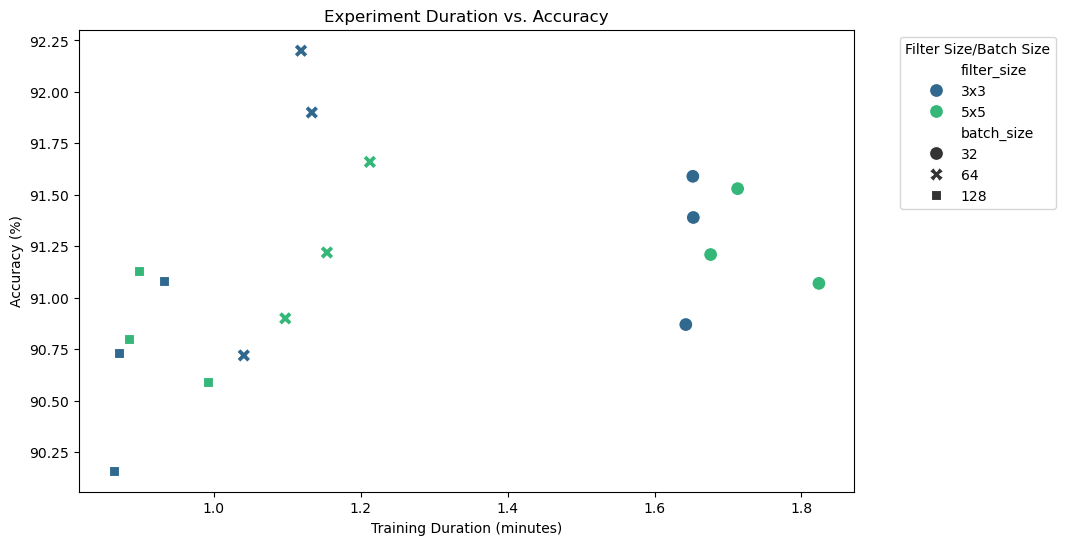

In [22]:
import pandas as pd

# Convert results to a DataFrame for easy plotting
data = []
for res in results:
    for record in res['history']:
        data.append({
            'filter_size': f"{res['filter_size'][0]}x{res['filter_size'][1]}",
            'features': f"{res['features'][0]}/{res['features'][1]}",
            'batch_size': res['batch_size'],
            'accuracy': res['accuracy'],
            'epoch': record['epoch'],
            'phase': record['phase'],
            'loss': record['loss'],
            'duration': res['duration'] / 60  # Convert to minutes for readability
        })

df = pd.DataFrame(data)


plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=experiment_results,
    x='duration', 
    y='accuracy', 
    hue='filter_size', 
    style='batch_size', 
    s=100, 
    palette='viridis'
)
plt.title("Experiment Duration vs. Accuracy")
plt.xlabel("Training Duration (minutes)")
plt.ylabel("Accuracy (%)")
plt.legend(title="Filter Size/Batch Size", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Analysis
* The most efficient model was the 3x3 filter size and 64 batch size(and 64/128 features)
* Overall the model is fairly accurate with the data but the model architecture or the optimization process is not very sensitive to the changes in these particular hyperparameters(as the range in accuracy's is pretty small)